# Dancer's business - 5. Get final result
In this notebook session, I will 
- predict local
    - fitness revenue,
    - dance studio revenue,
    - number of dance studio,
    - revenue per dance studio,
- discuss the result,
- select the best place.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/dance4.csv')

In [40]:
# Area to look
area_all = ['LA','SanFran','NY','Chicago','Seattle','All'] # All: U.S.
area_local = ['LA','SanFran','NY','Chicago','Seattle'] 

# Get the constants

In [4]:
g_rev = df.iloc[0].g_rev
r_biz = df.iloc[0].r_biz
rho = df.iloc[0].rho

g_rev_err = df.iloc[0].g_rev_err
r_biz_err = df.iloc[0].r_biz_err
rho_err = df.iloc[0].rho_err

# Error propagation formula

To multiply $x$ and $y$,

$$product=xy$$

$$product~error=\sqrt{y^2\sigma_x^2+x^2\sigma_y^2}$$



To divide $x$ and $y$,

$$division=x/y$$

$$division~error=|x/y|\sqrt{(\frac{\sigma_x}{x})^2 + (\frac{\sigma_y}{y})^2 }$$


To take average of $x$ and $y$,

$$weighted~mean = \frac{x/\sigma_x^2+y/\sigma_y^2}{1/\sigma_x^2+1/\sigma_y^2}$$

$$weighted~mean~error = \frac{1}{\sqrt{1/\sigma_x^2+1/\sigma_y^2}}$$

Recursively applying this method can take the average of more than two variables.

In [79]:
def ep_mul(x,y):
    
    return x*y

def ep_mul_err(x,y,ex,ey):
    
    return ((x*ey)**2+(y*ex)**2)**0.5

def ep_div(x,y):
    
    if y==0:
        return np.nan
    
    return x/y

def ep_div_err(x,y,ex,ey):
    
    if y==0:
        return np.nan
    
    return abs(x/y)*((ex/x)**2+(ey/y)**2)**0.5

def ep_mean(x,y,ex,ey):
    
    wx = 1/ex**2
    wy = 1/ey**2
    
    return (x*wx + y*wy)/(wx+wy)

def ep_mean_err(x,y,ex,ey):
    
    wx = 1/ex**2
    wy = 1/ey**2
        
    return (1/(wx+wy)**0.5)

def recur_ep_mean(x,ex):
    
    if len(x)<1:
        return False
    if len(x)==1:
        return x[0], ex[0]
    
    part_mean = ep_mean(x[0],x[1],ex[0],ex[1])
    part_err= ep_mean_err(x[0],x[1],ex[0],ex[1])
    
    if len(x)==2:
        return part_mean, part_err
    
    for i in range(2,len(x)):
        
        temp_mean = ep_mean(part_mean,x[i],part_err,ex[i])
        temp_err= ep_mean_err(part_mean,x[i],part_err,ex[i])
        
        part_mean = temp_mean
        part_err = temp_err
        
    
    return part_mean, part_err


# Predict local fitness revenue

In [6]:
# Calculate local fitness revenue
df['fitness_rev_pred'] = \
    df.apply(lambda x: ep_mul(x['vol'],x['g_rev']) if x['occ']=='fitness_biz' else np.nan, axis=1)

df['fitness_rev_pred_err'] =\
    df.apply(lambda x: ep_mul_err(x['vol'],x['g_rev'],x['vol_err'],x['g_rev_err']) \
             if x['occ']=='fitness_biz' else np.nan, axis=1)

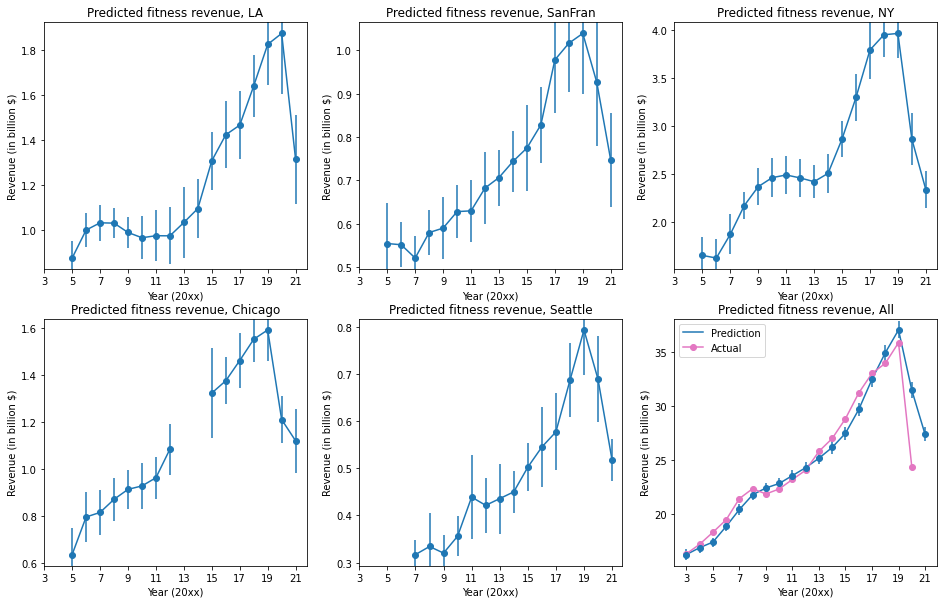

In [7]:
# Plot predicted local fitness revenue
plt.rcParams["figure.figsize"] = [16, 10]

fig, ax_arr = plt.subplots(2,3)

for i in range(len(area_all)):  

    t = df[(df.area==area_all[i])&(df.occ=='fitness_biz')]\
            [['year','fitness_rev_pred','fitness_rev_pred_err','fitness']]

    ax = ax_arr[i//3,i%3]
    
    x = t.year-2000
    y = t.fitness_rev_pred
    yerr = t.fitness_rev_pred_err
    
    ax = ax_arr[i//3,i%3]

    ax.plot(x, y, color='tab:blue', label='Prediction')
    ax.errorbar(x, y, yerr, fmt ='o', color='tab:blue')

    if area_all[i]=='All':
        y = t.fitness
        ax.plot(x, y, color='tab:pink',marker='o', label='Actual')
        ax.legend()
    
    ax.set_title('Predicted fitness revenue, '+area_all[i])
    ax.set_xlabel('Year (20xx)')
    ax.set_ylabel('Revenue (in billion $)')
    ax.set_xticks(np.arange(3, 22, 2))    
     

In the last plot, the pink is the actual nationwide data.
Are these reasonable?
Let's compare with available data.

## Cross check with other available data

The only area that I could find was NY.
[Source: Statista](https://www.statista.com/forecasts/1206968/fitness-and-recreational-sports-centres-revenue-in-new-york)
![Statista](data/ny_gym_rev.jpg)

From 2012-2019, the Statista's analysis (their source is premium information) the NY fitness revenue is from \\$2.8-3.6 billion, whereas my prediction is \\$2.4-3.9. The values are quite close.
The prediction in 2021, however, showed big difference.
That's because while the national fitness business is attacked harshly by COVID19, 
NY's fitness business was relatively robust, so prediction with national data showed big variance.
However, note that the definition of NY in my model is the metropolitan statistical area (MSA). It is not clear if NY in this Statista graph represents the city, MSA, or the state.

# Predict local dance studio revenue

In [8]:
# Calculate dance studio revenue
df['studio_rev_pred'] = \
    df.apply(lambda x: ep_mul(x['fitness_rev_pred'],x['r_biz']) \
             if x['occ']=='fitness_biz' else np.nan, axis=1)

df['studio_rev_pred_err'] =\
    df.apply(lambda x: ep_mul_err(x['fitness_rev_pred'],x['r_biz'],
                                  x['fitness_rev_pred_err'],x['r_biz_err']) \
             if x['occ']=='fitness_biz' else np.nan, axis=1)

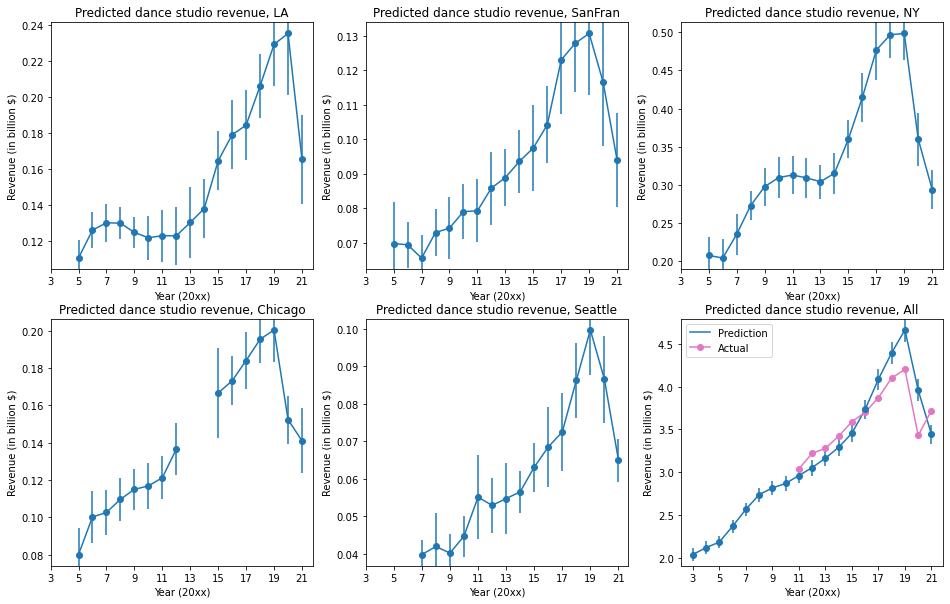

In [9]:
# Plot predicted local dance studio revenue
plt.rcParams["figure.figsize"] = [16, 10]

fig, ax_arr = plt.subplots(2,3)

for i in range(len(area_all)):  

    t = df[(df.area==area_all[i])&(df.occ=='fitness_biz')]\
            [['year','studio_rev_pred','studio_rev_pred_err','dance_studio']]

    ax = ax_arr[i//3,i%3]
    
    x = t.year-2000
    y = t.studio_rev_pred
    yerr = t.studio_rev_pred_err
    
    ax = ax_arr[i//3,i%3]

    ax.plot(x, y, color='tab:blue', label='Prediction')
    ax.errorbar(x, y, yerr, fmt ='o', color='tab:blue')

    if area_all[i]=='All':
        y = t.dance_studio
        ax.plot(x, y, color='tab:pink',marker='o', label='Actual')
        ax.legend()
    
    ax.set_title('Predicted dance studio revenue, '+area_all[i])
    ax.set_xlabel('Year (20xx)')
    ax.set_ylabel('Revenue (in billion $)')
    ax.set_xticks(np.arange(3, 22, 2))    

In the last plot, the pink is the actual nationwide data.

# Predict number of dance studio

In [10]:
# Calculate number of studio 
df['studio_num_pred'] = \
    df.apply(lambda x: ep_mul(x['vol'],x['rho']) \
             if x['occ']=='all_jobs' else np.nan, axis=1)

df['studio_num_pred_err'] =\
    df.apply(lambda x: ep_mul_err(x['vol'],x['rho'],
                                  x['vol_err'],x['rho_err']) \
             if x['occ']=='all_jobs' else np.nan, axis=1)

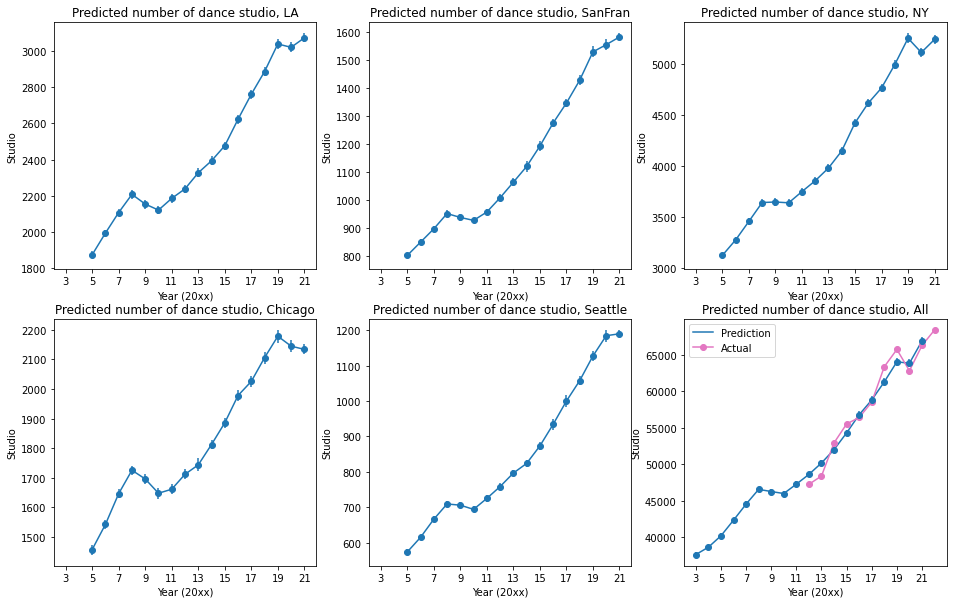

In [11]:
# Plot predicted local number of studio 
plt.rcParams["figure.figsize"] = [16, 10]

fig, ax_arr = plt.subplots(2,3)

for i in range(len(area_all)):  

    t = df[(df.area==area_all[i])&(df.occ=='all_jobs')&(df.year>2002)]\
            [['year','studio_num_pred','studio_num_pred_err','studio_num']]

    ax = ax_arr[i//3,i%3]
    
    x = t.year-2000
    y = t.studio_num_pred
    yerr = t.studio_num_pred_err
    
    ax = ax_arr[i//3,i%3]

    ax.plot(x, y, color='tab:blue', label='Prediction')
    ax.errorbar(x, y, yerr, fmt ='o', color='tab:blue')

    if area_all[i]=='All':
        y = t.studio_num
        ax.plot(x, y, color='tab:pink',marker='o', label='Actual')
        ax.legend()
    
    ax.set_title('Predicted number of dance studio, '+area_all[i])
    ax.set_xlabel('Year (20xx)')
    ax.set_ylabel('Studio')
    ax.set_xticks(np.arange(3, 22, 2))    

In the last plot, the pink points are the actual nationwide data.
Do this numbers sounds right?
Let's do a quick check.

![Google map of dance studio search](data/google.jpg)

This is a random Manhattan area, size of 1.6 km x 3.2 km = 5.1 km2, and there are 106 dance studio search results. (Keep in mind that this number can be overestimated due to google's generous selection. Search results start to include non-dance studios from 60-80 th result page.)
Since the size of Manhattan is 59 km2, there will be 106/5.1 km2 \* 59 km2 = 1200 dance studios in Manhattan (of half of them if the google gave results with 50% noise).
This number is 3-4 times smaller than my estimation of the NY metropolitan statistical area.
It won't be surprising that 1/4-1/3 of dance studios in the NY metropolitan area are in Manhattan.

# Predict revenue per dance studio

In [12]:
# Organize data table
for area in df.area.unique():
    for year in df.year.unique():
        
        t = df[(df.area==area)&(df.year==year)]
        
        if len(t.fitness_rev_pred.dropna())!=1:
            continue
        else:
        
            fitness_rev_pred     = t.fitness_rev_pred.dropna().squeeze()
            fitness_rev_pred_err = t.fitness_rev_pred_err.dropna().squeeze()

            studio_rev_pred      = t.studio_rev_pred.dropna().squeeze()
            studio_rev_pred_err  = t.studio_rev_pred_err.dropna().squeeze()

            studio_num_pred      = t.studio_num_pred.dropna().squeeze()
            studio_num_pred_err  = t.studio_num_pred_err.dropna().squeeze()
            
            df.loc[(df.area==area)&(df.year==year),
                   'fitness_rev_pred'] = fitness_rev_pred
            df.loc[(df.area==area)&(df.year==year),
                   'fitness_rev_pred_err'] = fitness_rev_pred_err
            
            df.loc[(df.area==area)&(df.year==year),
                   'studio_rev_pred'] = studio_rev_pred
            df.loc[(df.area==area)&(df.year==year),
                   'studio_rev_pred_err'] = studio_rev_pred_err
            
            df.loc[(df.area==area)&(df.year==year),
                   'studio_num_pred'] = studio_num_pred
            df.loc[(df.area==area)&(df.year==year),
                   'studio_num_pred_err'] = studio_num_pred_err

In [13]:
# Calculate per studio revenue
df['per_studio_rev_pred'] = \
    df.apply(lambda x: ep_div(x['studio_rev_pred'],x['studio_num_pred']), axis=1)

df['per_studio_rev_pred_err'] =\
    df.apply(lambda x: ep_div_err(x['studio_rev_pred'],x['studio_num_pred'],
                                  x['studio_rev_pred_err'],x['studio_num_pred_err']), axis=1)

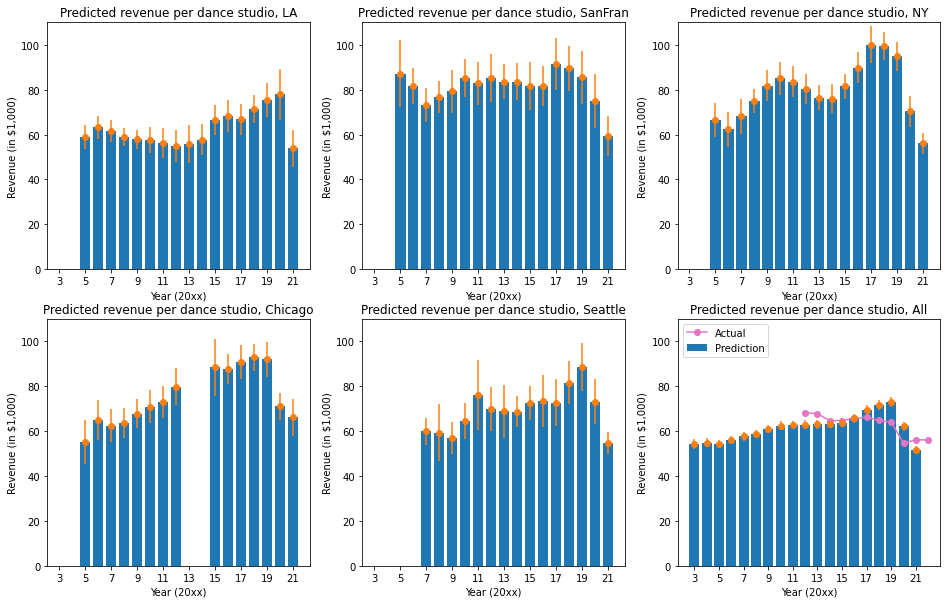

In [17]:
# Plot predicted local number of studio 
plt.rcParams["figure.figsize"] = [16, 10]

fig, ax_arr = plt.subplots(2,3)

billion_to_k=1000000

for i in range(len(area_all)):  

    t = df[(df.area==area_all[i])&(df.occ=='all_jobs')&(df.year>2002)]\
            [['year','per_studio_rev_pred','per_studio_rev_pred_err',
              'dance_studio','studio_num']]

    ax = ax_arr[i//3,i%3]
    
    x = t.year-2000
    y = t.per_studio_rev_pred*billion_to_k
    yerr = t.per_studio_rev_pred_err*billion_to_k
    
    ax = ax_arr[i//3,i%3]

    ax.bar(x, y, color='tab:blue', label='Prediction')
    ax.errorbar(x, y, yerr, fmt ='o', color='tab:orange')

    if area_all[i]=='All':
        y = t.dance_studio/t.studio_num*billion_to_k
        ax.plot(x, y, color='tab:pink',marker='o', label='Actual')
        ax.legend()
    
    ax.set_title('Predicted revenue per dance studio, '+area_all[i])
    ax.set_xlabel('Year (20xx)')
    ax.set_ylabel('Revenue (in $1,000)')
    ax.set_ylim(0,110)
    ax.set_xticks(np.arange(3, 22, 2))    

Finally we have the revenue per studio!

# Discussion and conclusion


To summarize how we predicted the local dance studio's revenue,
we calculated the following equation.

$$R_{Studio}^{City} = \frac{r_{biz} ~ g_{rev} ~ V_{Gym}^{City}}{\rho_{density} ~ V_{All~jobs}^{City}}$$


The constants are selected and calculated using the nationwide data as below.

$$r_{biz} = \frac{R_{Studio}}{R_{Gym}}$$

$$g_{rev} = \frac{R_{Gym}}{V_{Gym}}$$

$$\rho_{density} = \frac{N_{Studio}}{V_{All~jobs}}$$

Throughout this analysis, 
- I **assumed those constants are universal, same in all area**.
However, there's no reason to remove posibility that it is not true.
For example, a certain city might have more interest in dance, having larger $r_{biz}$;
fitness workers in certain city might get higher fraction of sports center's income, having smaller $g_{rev}$; 
or a certain city have more competition between dance studios, having larger $\rho_{density}$.
Therefore, **to improve this model, having local business data will be very useful**.

- In the revenue prediction formula, the local dependent variables are $V_{Gym}^{City}/V_{All~jobs}^{City}$.
Here, by dividing wage by wage, the effect of **different price levels between area were cancelled out**. Such values need to be adjusted to predict actual revenue.


## Wage comparison between jobs

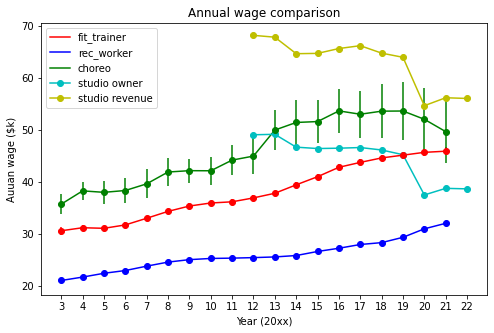

In [35]:
# Plot wage
plt.rcParams["figure.figsize"] = [8, 5]

fig, ax_arr = plt.subplots()


ijob=0
color = ['r','b','g','k','c','y']
for job in ('fit_trainer','rec_worker','choreo'):
    
    t = df[(df.area=='All')&(df.occ==job)]

    x = t.year-2000
    y = t.a_mean/1000
    yerr = t.a_mean_err/1000

    ax = ax_arr

    ax.plot(x, y, color=color[ijob], label=job)
    ax.errorbar(x, y, yerr, fmt ='o', color=color[ijob])
    
    ijob+=1
    
t = df[(df.area=='All')&(df.occ=='all_jobs')]

x = t.year-2000
y = t.per_studio_owner_a_mean/1000

ax.plot(x, y, color=color[4], marker='o', label='studio owner')

y = t.per_studio_a_mean/1000
ax.plot(x, y, color=color[5], marker='o', label='studio revenue')

ax.set_title('Annual wage comparison')
ax.set_xlabel('Year (20xx)')
ax.set_ylabel('Auuan wage ($k)')
ax.set_xticks(np.arange(3, 23, 1.0))   
ax.legend()
    


- Dance studio's revenue is higher than the rest, but after subtracting average 2 employee's 20k annual salary, the revenue becomes middle.
- On top of that, after subtracting cost, saying 20k of studio rent fee, it might be tougher to run. **If you are not certain about the studio running, I would recommend to start to run a dance class as an employed dancer of recreational worker.**
- Recreational worker's wage is lower than fitness trainers.
- **If I were a dance studio owner, I would run the dance class program and hire a few recreational workers to run fitness programs** because of two reasons.
    - There are more demand for fitness businesses.
    - Recreational worker's salary is lower than dancer's salary.
- Don't confuse this recommendation as fitness studio will be more advantagous. If you compare the revenue drop in 2020, dance studio's revenue drop was less severe than that of fitness. **It might imply that dance studio customers are more loyal (see the plot below), although it could be just a hasty generalization.**

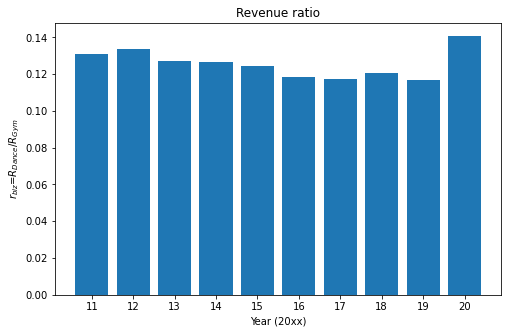

In [37]:
plt.rcParams["figure.figsize"] = [8, 5]
fig, ax_arr = plt.subplots()
t = df[(df.area=='All')&(df.occ=='all_jobs')&(t.year>=1998)]
# Revenue/Revenue, yearly
ax = ax_arr

x = t.year-2000
y = t.dance_studio/t.fitness

ax.bar(x, y)
ax.set_title('Revenue ratio')
ax.set_xlabel('Year (20xx)')
_= ax.set_ylabel('$r_{biz}$=$R_{Dance}$/$R_{Gym}$')
_= ax.set_xticks(np.arange(11,21, 1.0))

## Comparison between area
That's what matters a lot!

### Predicted dance studio revenue and its interpretation

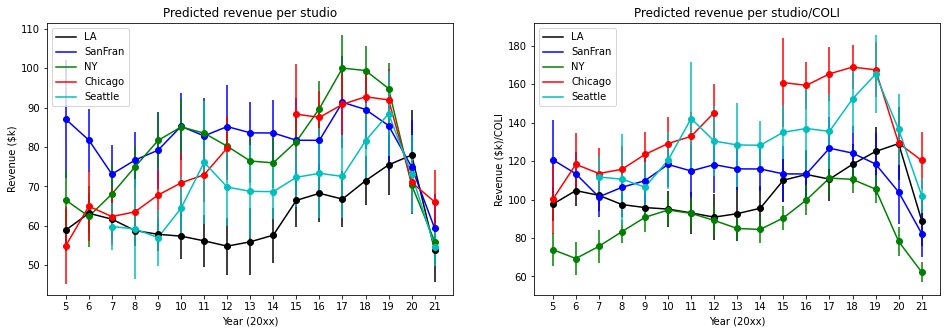

In [44]:
# Revenue comparison

plt.rcParams["figure.figsize"] = [16, 5]

fig, ax_arr = plt.subplots(1,2)

    
for i in range(len(area_local)):
        
    t = df[(df.area==area_local[i])&(df.occ=='all_jobs')&(df.year>2004)]

    x = t.year-2000
    
    # Revenue
    y = t.per_studio_rev_pred*billion_to_k
    yerr = t.per_studio_rev_pred_err*billion_to_k

    ax = ax_arr[0]

    ax.plot(x, y, color=color[i], label=area_local[i])
    ax.errorbar(x, y, yerr, fmt ='o', color=color[i])

    ax.set_title('Predicted revenue per studio')
    ax.set_xlabel('Year (20xx)')
    ax.set_ylabel('Revenue ($k)')
    ax.set_xticks(np.arange(5, 22, 1.0))   
    ax.legend()
    
    # Revenue/COLI
    y = t.per_studio_rev_pred/t.coli_cpi*billion_to_k
    yerr = t.per_studio_rev_pred_err/t.coli_cpi*billion_to_k

    ax = ax_arr[1]

    ax.plot(x, y, color=color[i], label=area_local[i])
    ax.errorbar(x, y, yerr, fmt ='o', color=color[i])

    ax.set_title('Predicted revenue per studio/COLI')
    ax.set_xlabel('Year (20xx)')
    ax.set_ylabel('Revenue ($k)/COLI')
    ax.set_xticks(np.arange(5, 22, 1.0))   
    ax.legend()

- (Right plot) After adjusting with the COLI of 2010, **Chicago and Seattle** seems the best place to open a dance studio wheres NY is the least prefered place. Keep in mind that the COLI is from 2010. The fast increase of recent Seattle's cost of living is not adjusted.
- (Left plot) However, actual local differences in this plot comes from different $V_{Gym}/V_{All~jobs}$ of each area. Although these numbers will properly predict the scale of dance studio's revenue in each area, the difference between area is just $V_{Gym}/V_{All~jobs}$. Small this value might imply that there are less fitness businesses than potential demand. In that point of view, **Seattle and LA** could be a best places to choose.


### Dancer and recreational workers per resident

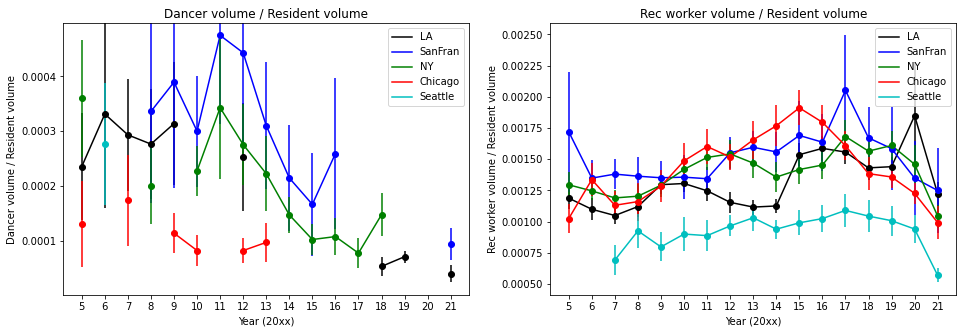

In [45]:
plt.rcParams["figure.figsize"] = [16, 5]

fig, ax_arr = plt.subplots(1,2)

    
for i in range(len(area_local)):
        
    t0 = df[(df.area==area_local[i])&(df.occ=='dance_biz')&(df.year>2004)]
    t1 = df[(df.area==area_local[i])&(df.occ=='all_jobs')&(df.year>2004)]
    
    t = t0.merge(t1,how='inner',on='year')

    x = t.year-2000
    
    # Dancer/Resident
    y = t.vol_x/t.vol_y
    yerr = t.vol_err_x/t.vol_y # ignore much smaller error of all jobs

    ax = ax_arr[0]

    ax.plot(x, y, color=color[i], label=area_local[i])
    ax.errorbar(x, y, yerr, fmt ='o', color=color[i])

    ax.set_title('Dancer volume / Resident volume')
    ax.set_xlabel('Year (20xx)')
    ax.set_ylabel('Dancer volume / Resident volume')
    ax.set_xticks(np.arange(5, 22, 1.0))   
    ax.legend()
    
    # Rec worker/resident
    t0 = df[(df.area==area_local[i])&(df.occ=='rec_worker')&(df.year>2004)]
    t1 = df[(df.area==area_local[i])&(df.occ=='all_jobs')&(df.year>2004)]
    
    t = t0.merge(t1,how='inner',on='year')

    x = t.year-2000
    
    # Rec worker/ Resident
    y = t.vol_x/t.vol_y
    yerr = t.vol_err_x/t.vol_y # ignore much smaller error of all jobs
    
    ax = ax_arr[1]

    ax.plot(x, y, color=color[i], label=area_local[i])
    ax.errorbar(x, y, yerr, fmt ='o', color=color[i])

    ax.set_title('Rec worker volume / Resident volume')
    ax.set_xlabel('Year (20xx)')
    ax.set_ylabel('Rec worker volume / Resident volume')
    ax.set_xticks(np.arange(5, 22, 1.0))   
    ax.legend()

- There are O(10) times more recreaional worker volumes than dancers in all area.
- **Chicago has less dancer volume** and **Seattle has less recreational worker volume** than the other area.

### Trend of volume - grow or decrease?

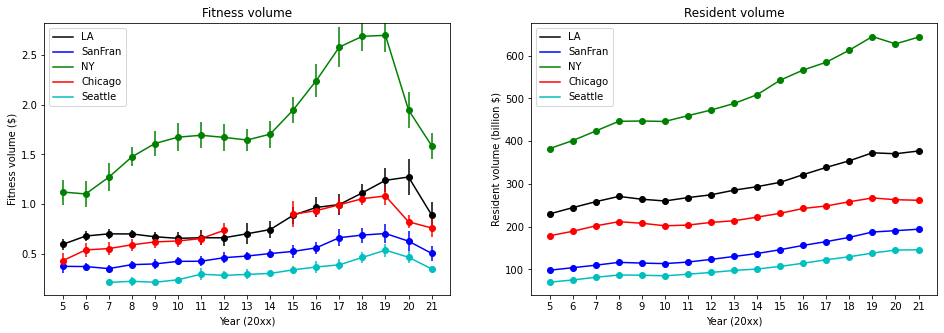

In [47]:
plt.rcParams["figure.figsize"] = [16, 5]

fig, ax_arr = plt.subplots(1,2)

    
for i in range(len(area_local)):
        
    t = df[(df.area==area_local[i])&(df.occ=='fitness_biz')&(df.year>2004)]

    x = t.year-2000
    
    # Fitness
    y = t.vol
    yerr = t.vol_err

    ax = ax_arr[0]

    ax.plot(x, y, color=color[i], label=area_local[i])
    ax.errorbar(x, y, yerr, fmt ='o', color=color[i])

    ax.set_title('Fitness volume')
    ax.set_xlabel('Year (20xx)')
    ax.set_ylabel('Fitness volume ($)')
    ax.set_xticks(np.arange(5, 22, 1.0))   
    ax.legend()
    
    # Resident
    t = df[(df.area==area_local[i])&(df.occ=='all_jobs')&(df.year>2004)]
    
    x = t.year-2000
    
    # Resident
    y = t.vol
    yerr = t.vol_err
    
    ax = ax_arr[1]

    ax.plot(x, y, color=color[i], label=area_local[i])
    ax.errorbar(x, y, yerr, fmt ='o', color=color[i])

    ax.set_title('Resident volume')
    ax.set_xlabel('Year (20xx)')
    ax.set_ylabel('Resident volume (billion $)')
    ax.set_xticks(np.arange(5, 22, 1.0))   
    ax.legend()

Trends seem similar. Let's compare growth in percent.

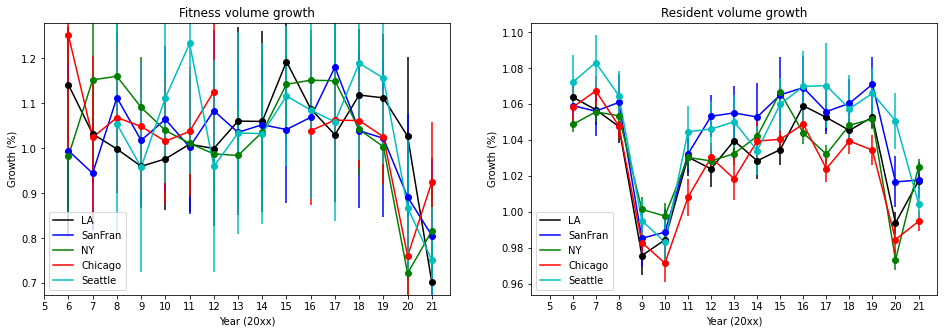

In [53]:
plt.rcParams["figure.figsize"] = [16, 5]

fig, ax_arr = plt.subplots(1,2)

    
for i in range(len(area_local)):
        
    t = df[(df.area==area_local[i])&(df.occ=='fitness_biz')&(df.year>2004)]
    x = t.year-2000
    
    # Fitness
    y = t.vol
    yerr = t.vol_err

    a = y.to_numpy()
    ea = yerr.to_numpy()
    b = [np.nan]
    eb = [np.nan]

    for j in range(1,len(a)):
        b.append(a[j]/a[j-1])
        eb.append(ep_div_err(a[j],a[j-1],ea[j],ea[j-1]))
        
    y = b
    yerr = eb
        
    
    ax = ax_arr[0]

    ax.plot(x, y, color=color[i], label=area_local[i])
    ax.errorbar(x, y, yerr, fmt ='o', color=color[i])

    ax.set_title('Fitness volume growth')
    ax.set_xlabel('Year (20xx)')
    ax.set_ylabel('Growth (%)')
    ax.set_xticks(np.arange(5, 22, 1.0))   
    ax.legend()
    
    # Resident
    t = df[(df.area==area_local[i])&(df.occ=='all_jobs')&(df.year>2004)]
    
    x = t.year-2000
    
    # Resident
    y = t.vol
    yerr = t.vol_err
    
    a = y.to_numpy()
    ea = yerr.to_numpy()
    b = [np.nan]
    eb = [np.nan]

    for j in range(1,len(a)):
        b.append(a[j]/a[j-1])
        eb.append(ep_div_err(a[j],a[j-1],ea[j],ea[j-1]))
        
    y = b
    yerr = eb
        
    
    ax = ax_arr[1]

    ax.plot(x, y, color=color[i], label=area_local[i])
    ax.errorbar(x, y, yerr, fmt ='o', color=color[i])

    ax.set_title('Resident volume growth')
    ax.set_xlabel('Year (20xx)')
    ax.set_ylabel('Growth (%)')
    ax.set_xticks(np.arange(5, 22, 1.0))   
    ax.legend()

- The uncertainties in fitness volume growth is large. It is hard to compare.
- The resident volume growth follows similar trend between different area.
- It seems **Seattle and San Francisco**'s **resident volume growth** is largest overall.

# Conclusion

Here's summary from the project.

## Revenue trend and modeling constant
- Both of fitness and dance studio businesses are growing.
- The market size of fitness industry is proportianal to that of dance studio, 7-8 times larger for recent decade.
- The fitness employment volume is proportional to its market size, 60-70% of the revenue.
- The number of dance studio is proportional to the size of the employed residents' income.
- Those proportionalities are assumed to be area independent in this modeling and used to predict the revenue of a dance studio of each area. The only area dependent data were the size of fitness employment volume and the size of the employed residents' income, which can be found from the government wage statistics.

## To improve
- Definitely, any local revenue or number of businesses data will be very useful to improve this model. That will also help me a lot to decide where to live. I would choose an area with low [fitness employee volume]/[number of dance studio].
- This analysis gave me interesting findings. I'd like to analyze more area, too!
- Generally, all trends were changed since Covid19. Keep that in mind.


## Choose area
- Seattle has the best wage for dance and fitness industry workers, considering the cost of living index of 2010. This number need adjustment for newer value.
- The resident volume growth is also high in Seattle. Although the revenue of dance studio might grow accordingly, there's potential to bring more competitors as well. However, the growth in Seattle could be from tech companies' growth, who are not competitors of dance studio industry. They could be rather potential customers, who are interested in fitness.
- I'm interested in to do this analyis for more places.
- Meanwhile, importantly, income is not the only factor you will consider. You might be interested in other factors considering your career goal, such as where best dancers perform, which cities are good for artists, or which cities have more female population in ages 20-60s, who will willing to spend on both practicing and watching dance.

## Choose between similar jobs
 - Running a dance studio is not expected to give significantly more income compared to other employed jobs. Therefore, I wouldn't recommend running a studio from the beginning.
 - I'd rather recommend to start to run a dance class as an employed choreographer or recreational worker.

## How would I run a dance studio
- If I were a dance studio owner, I would run the dance class program by myself and hire a few recreational workers to run fitness programs because there are more demand for fitness businesses, and recreational worker's salary is lower than dancer's salary.